# Install required libraries

In [2]:
!pip install transformers datasets seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 K

# Import Libraries

In [3]:
from transformers import LayoutLMv3FeatureExtractor, LayoutLMv3Tokenizer, LayoutLMv3Processor
from PIL import Image
import torch
from datasets import load_dataset
from datasets.features import ClassLabel
from PIL import ImageDraw, ImageFont
import random


In [4]:
# Make sure device is set to GPU if avaiable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

processor_id = "microsoft/layoutlmv3-base"
# Load pre trained layoutlmv3 processor = feature extraction + tokenizer + processor and set ocr is false
processor = LayoutLMv3Processor.from_pretrained(processor_id, apply_ocr=False)

cuda


In [5]:
# Load dataset from huggingface https://huggingface.co/datasets/pierreguillou/DocLayNet-small
# DocLayNet is present in three size: small, base, large
# We will use small as we have only 15 GB RAM in colab
dataset_id ="pierreguillou/DocLayNet-small"

dataset = load_dataset(dataset_id)

print(f"Train dataset size: {len(dataset['train'])}")
print(f"Test dataset size: {len(dataset['test'])}")
# Train dataset size: 691
# Test dataset size: 49


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset doc_lay_net-small downloaded and prepared to /root/.cache/huggingface/datasets/pierreguillou___doc_lay_net-small/DocLayNet_2022.08_processed_on_2023.01/1.1.0/9a545168f32e0dc98a6deb7670c5c48a0fb7261b6248da74b38a596072625332. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Train dataset size: 691
Test dataset size: 49


In [6]:
# Remove data which has no text
dataset = dataset.filter(lambda example: len(example['texts']) > 0)

Filter:   0%|          | 0/691 [00:00<?, ? examples/s]

Filter:   0%|          | 0/64 [00:00<?, ? examples/s]

Filter:   0%|          | 0/49 [00:00<?, ? examples/s]

In [7]:
# Check size of Dataset
print(f"Train dataset size: {len(dataset['train'])}")
print(f"Test dataset size: {len(dataset['test'])}")

Train dataset size: 688
Test dataset size: 49


In [8]:
# Make sure bounding box and categories have same length 
dataset = dataset.filter(lambda example: len(example['bboxes_block'])==len(example["categories"]))
print(f"Train dataset size: {len(dataset['train'])}")
print(f"Test dataset size: {len(dataset['test'])}")

Filter:   0%|          | 0/688 [00:00<?, ? examples/s]

Filter:   0%|          | 0/63 [00:00<?, ? examples/s]

Filter:   0%|          | 0/49 [00:00<?, ? examples/s]

Train dataset size: 688
Test dataset size: 49


In [9]:
# Make sure Text and categories have same length 
dataset = dataset.filter(lambda example: len(example['texts'])==len(example["categories"]))
print(f"Train dataset size: {len(dataset['train'])}")
print(f"Test dataset size: {len(dataset['test'])}")

Filter:   0%|          | 0/688 [00:00<?, ? examples/s]

Filter:   0%|          | 0/63 [00:00<?, ? examples/s]

Filter:   0%|          | 0/49 [00:00<?, ? examples/s]

Train dataset size: 688
Test dataset size: 49


# Explore Dataset

In [10]:
dataset['train'].features

{'id': Value(dtype='string', id=None),
 'texts': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'bboxes_block': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'bboxes_line': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'categories': Sequence(feature=ClassLabel(names=['Caption', 'Footnote', 'Formula', 'List-item', 'Page-footer', 'Page-header', 'Picture', 'Section-header', 'Table', 'Text', 'Title'], id=None), length=-1, id=None),
 'image': Image(decode=True, id=None),
 'page_hash': Value(dtype='string', id=None),
 'original_filename': Value(dtype='string', id=None),
 'page_no': Value(dtype='int32', id=None),
 'num_pages': Value(dtype='int32', id=None),
 'original_width': Value(dtype='int32', id=None),
 'original_height': Value(dtype='int32', id=None),
 'coco_width': Value(dtype='int32', id=None),
 'coco_height': Value(dtype='int32', id=None),

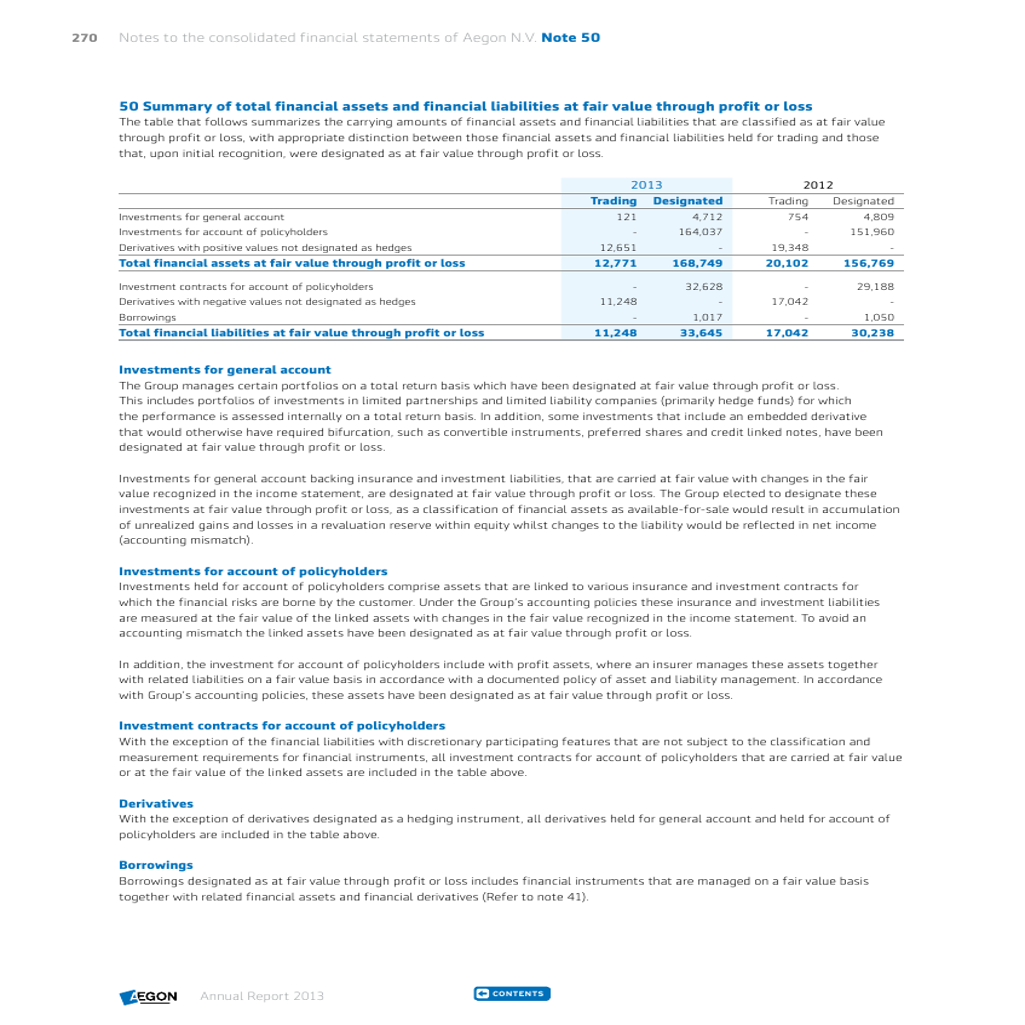

In [11]:
example = dataset["train"][0]
example["image"]

In [12]:
words, boxes, ner_tags = example["texts"], example["bboxes_block"], example["categories"]
print(words)
print(boxes)
print(ner_tags)

['Notes to the consolidated financial statements of Aegon N.V. ', 'Note 50', '270', '50', 'Summary of total financial assets and financial liabilities at fair value through profit or loss', 'Investments for general account', 'Investments for account of policyholders', 'Investment contracts for account of policyholders', 'Derivatives', 'Borrowings ', 'The table that follows summarizes the carrying amounts of financial assets and financial liabilities that are classified as at fair value ', 'through profit or loss, with appropriate distinction between those financial assets and financial liabilities held for trading and those ', 'that, upon initial recognition, were designated as at fair value through profit or loss.', 'The Group manages certain portfolios on a total return basis which have been designated at fair value through profit or loss. ', 'This includes portfolios of investments in limited partnerships and limited liability companies (primarily hedge funds) for which ', 'the perf

## Get label list

In [13]:
features = dataset["train"].features
column_names = dataset["train"].column_names
image_column_name = "image"
text_column_name = "texts"
boxes_column_name = "bboxes_block"
label_column_name = "categories"

# In the event the labels are not a `Sequence[ClassLabel]`, we will need to go through the dataset to get the
# unique labels.
def get_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    return label_list

if isinstance(features[label_column_name].feature, ClassLabel):
    label_list = features[label_column_name].feature.names
    # No need to convert the labels since they are already ints.
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
else:
    label_list = get_label_list(dataset["train"][label_column_name])
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
num_labels = len(label_list)
     

In [14]:
print(label_list)

['Caption', 'Footnote', 'Formula', 'List-item', 'Page-footer', 'Page-header', 'Picture', 'Section-header', 'Table', 'Text', 'Title']


In [15]:
print(id2label)

{0: 'Caption', 1: 'Footnote', 2: 'Formula', 3: 'List-item', 4: 'Page-footer', 5: 'Page-header', 6: 'Picture', 7: 'Section-header', 8: 'Table', 9: 'Text', 10: 'Title'}


## Let's visulize bounding Box and labels on image

In [16]:
# Define colors for all labels
get_colors = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))
colors = get_colors(len(label_list))
font = ImageFont.load_default()
label2color = {label: colors[idx] for idx, label in enumerate(label_list)}

In [17]:
coco_width = example['coco_width']
coco_height = example['coco_height']
categories_list = example['categories']
bboxs_list = example['bboxes_block']
original_width, original_height = example["original_width"], example["original_height"]
image = example['image']
resized_image = image.resize(size=(1000,1000))
image_width, image_height = image.size
(image_width, image_height), (coco_width,coco_height), (original_width, original_height)

((1025, 1025), (1025, 1025), (609, 793))

In [18]:
draw_1 = ImageDraw.Draw(image, "RGBA")

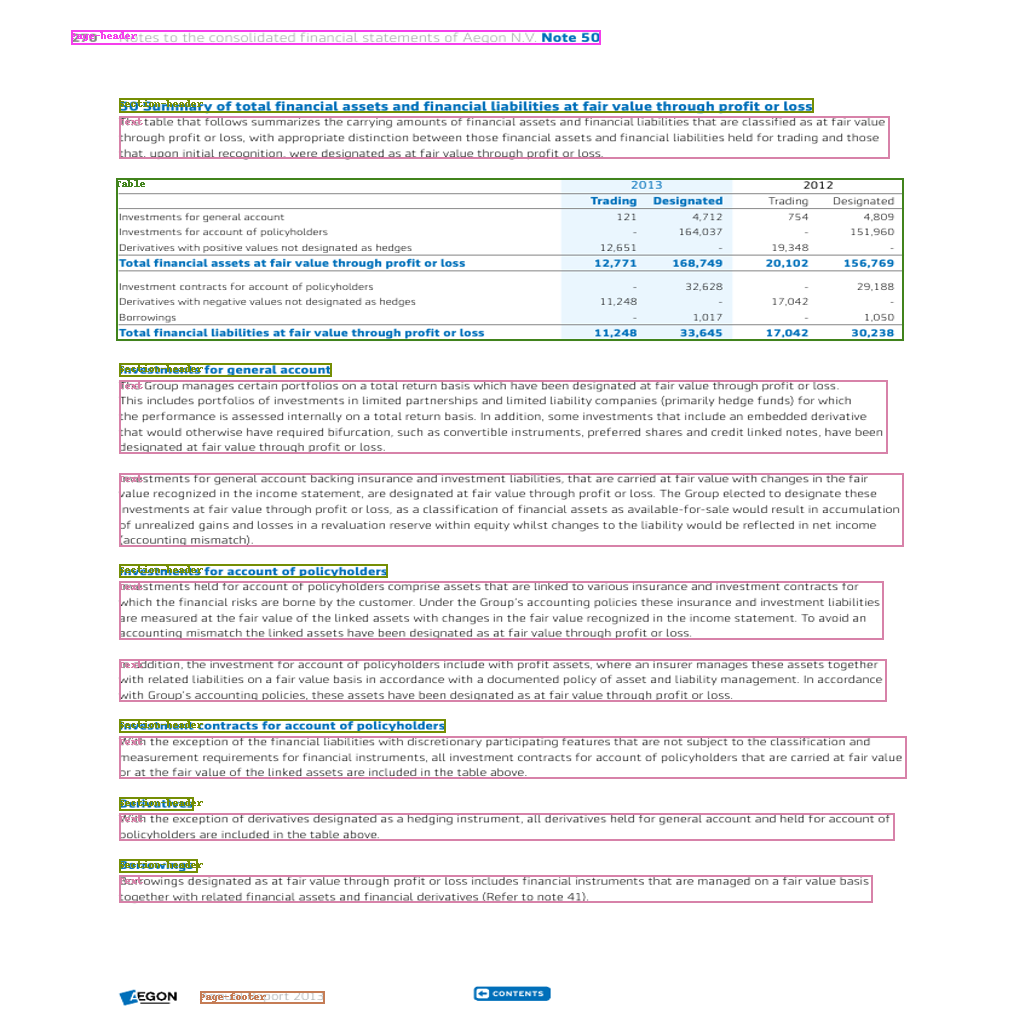

In [19]:
# We are visulizing boxes on original imag
for categorie, box in zip( categories_list, bboxs_list):
    x, y, w, h = tuple(box) # the row comes in (left, top, width, height) format
    box = [x, y, x+w, y+h]
    draw_1.rectangle(box, outline=label2color[id2label[categorie]], width=2)
    draw_1.text((box[0], box[1]), id2label[categorie], fill=label2color[id2label[categorie]], font=font, size=20)

image

In [20]:
image.size

(1025, 1025)

### Resize image and bounding box to 1000*1000 because layoutlm expect bounding box to be normalized https://huggingface.co/docs/transformers/model_doc/layoutlm 

In [21]:
# Normalize box diamentions to range 0 to 1000
def normalized_box(box, image_width, image_height):
    return [
        int(1000 * (box[0] / image_width)),
        int(1000 * (box[1] / image_height)),
        int(1000 * (box[2] / image_width)),
        int(1000 * (box[3] / image_height)),
    ]
def convert_box(bbox):
    x, y, w, h = tuple(bbox) # Box coordinates are in (left, top, width, height) format
    return [x, y, x+w, y+h] # we need to convert it into (x1, y1, x2, y2) which is (left, top, left+widght, top+height)

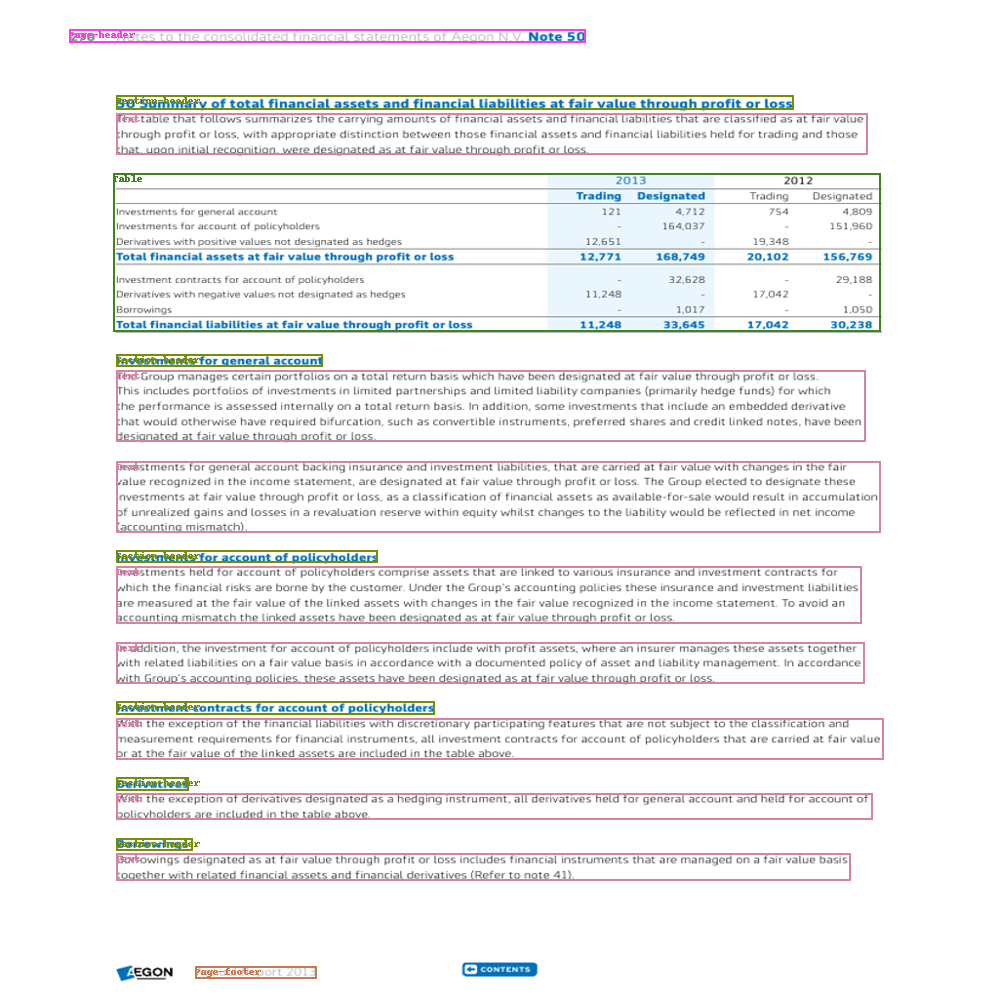

In [22]:
normalized_bboxes_list = [normalized_box(convert_box(bboxs), image_width, image_height) for bboxs in bboxs_list]
draw_2 = ImageDraw.Draw(resized_image, "RGBA")
# We are visulizing boxes on original imag
for categorie, box in zip( categories_list, normalized_bboxes_list):
    draw_2.rectangle(box, outline=label2color[id2label[categorie]], width=2)
    draw_2.text((box[0], box[1]), id2label[categorie], fill=label2color[id2label[categorie]], font=font, size=20)

resized_image

In [23]:
resized_image.size

(1000, 1000)

# Prepare Dataset for training

In [24]:
def prepare_examples(examples):
    images = examples[image_column_name]
    words = examples[text_column_name]
    bboxes = examples[boxes_column_name]
    word_labels = examples[label_column_name]
    
    unique_boxes_list = []
    for img, boxs in zip(images, bboxes):
        width, height = img.size
        original_bboxes_list = [normalized_box(convert_box(box), width, height) for box in boxs]
    
        unique_boxes_list.append(original_bboxes_list)
    #https://github.com/huggingface/transformers/issues/19190
    encoding = processor(images, words, boxes=unique_boxes_list,word_labels=word_labels,
                         max_length=512, padding="max_length", stride=128, truncation=True, 
                         return_overflowing_tokens=True, return_offsets_mapping =True)
    offset_mapping = encoding.pop('offset_mapping')

    overflow_to_sample_mapping = encoding.pop('overflow_to_sample_mapping')

    return encoding

In [25]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

# we need to define custom features for `set_format` (used later on) to work properly
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})

train_dataset = dataset["train"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
    batch_size=2,
)
eval_dataset = dataset["test"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
    batch_size=2,
)

val_dataset = dataset["validation"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
    batch_size=2,
)

Map:   0%|          | 0/688 [00:00<?, ? examples/s]

Map:   0%|          | 0/49 [00:00<?, ? examples/s]

In [29]:
train_dataset.set_format("torch")

In [30]:
import torch

example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

pixel_values torch.Size([3, 224, 224])
input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])


In [31]:
eval_dataset.set_format("torch")
val_dataset.set_format("torch")

In [32]:
from datasets import load_metric

metric = load_metric("seqeval")

<ipython-input-32-edef154daec7>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")


In [33]:
import numpy as np

return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }


In [34]:
from transformers import LayoutLMv3ForTokenClassification

model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",
                                                         id2label=id2label,
                                                         label2id=label2id)

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
import gc
import torch
gc.collect()

torch.cuda.empty_cache()

In [36]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
                                    output_dir="./layoutlmv3-finetuned-DocLayNet",# Output directory
                                    max_steps=500,                              # Maximum number of training steps
                                    per_device_train_batch_size=2,               # Batch size for training
                                    per_device_eval_batch_size=2,                # Batch size for evaluation
                                    push_to_hub=False,                           # Do not push the model to the Hugging Face model hub
                                    learning_rate=1e-5,                          # Learning rate for the optimizer
                                    evaluation_strategy="steps",                 # Evaluate every "eval_steps" steps
                                    eval_steps=100,                              # Evaluate every 250 steps
                                    save_strategy="steps",                       # Save checkpoints every "save_steps" steps
                                    save_steps=100,                             # Save checkpoints every 1000 steps
                                    logging_dir='./logs',                        # Directory for storing logs
                                    logging_steps=100,                           # Log every "logging_steps" steps
                                    load_best_model_at_end=True,                 # Load the best model when finished training
                                    metric_for_best_model="accuracy",            # Use accuracy as the metric to compare models
                                    greater_is_better = True                     # Indicate whether the metric is to be maximized or minimized
)

In [37]:
from transformers.data.data_collator import default_data_collator


# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

In [38]:
# CUDA_LAUNCH_BLOCKING flag helps to debug GPU error
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [39]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/modeling_utils.py:830: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,1.638800,1.225465,0.113122,0.079114,0.093110,0.642895
200,1.248400,1.021583,0.148862,0.268987,0.191657,0.694549
300,0.979800,0.726191,0.259554,0.515823,0.345339,0.839142
400,0.909800,0.603434,0.304505,0.534810,0.388060,0.862556
500,0.790300,0.605067,0.338462,0.556962,0.421053,0.862735


/usr/local/lib/python3.9/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Text seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Picture seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Caption seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Section-header seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Table seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/dist-packages/seqeval/metrics/sequence_labe

TrainOutput(global_step=500, training_loss=1.113420379638672, metrics={'train_runtime': 300.6193, 'train_samples_per_second': 3.326, 'train_steps_per_second': 1.663, 'total_flos': 265429091328000.0, 'train_loss': 1.113420379638672, 'epoch': 0.73})

In [40]:
trainer.evaluate(val_dataset)

/usr/local/lib/python3.9/dist-packages/transformers/modeling_utils.py:830: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


/usr/local/lib/python3.9/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Section-header seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Text seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Picture seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Caption seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Page-footer seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/dist-packages/seqeval/metrics/sequenc

{'eval_loss': 0.5933617353439331,
 'eval_precision': 0.37082601054481545,
 'eval_recall': 0.6107091172214182,
 'eval_f1': 0.46145434663750684,
 'eval_accuracy': 0.8248558616271621,
 'eval_runtime': 13.6258,
 'eval_samples_per_second': 10.788,
 'eval_steps_per_second': 5.431,
 'epoch': 0.73}